In [1]:
#Graphing
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
from datetime import datetime
from scipy import stats
import requests
import json

from config import ConsumerKey, ConsumerSecret, AccessToken, AccessTokenSecret
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(ConsumerKey, ConsumerSecret)
auth.set_access_token(AccessToken, AccessTokenSecret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

movie_data_df = pd.read_csv('all_movie_data.csv')
movie_data_df = movie_data_df.loc[(movie_data_df['tweet_count']>10)]
# movie_data_df.head()

In [2]:
genres = movie_data_df['genre'].unique()

In [3]:
groupedGenre = movie_data_df.groupby(['genre'])

In [4]:
groupedBudget = groupedGenre['budget'].sum()

In [5]:
groupedOpen = groupedGenre['opening'].sum()

In [6]:
groupedSummary = pd.DataFrame({"budget":groupedBudget,
                             "opening":groupedOpen})
# groupedSummary

In [7]:
# Index by title
title_index_df = movie_data_df.set_index(['title'])

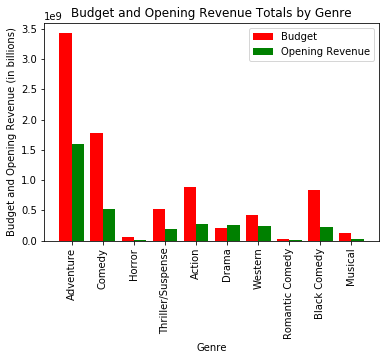

In [8]:
#1matt: compare revenue and opening weekend revenue sorted by genre
plt.bar(np.arange(len(groupedSummary))-.20, groupedSummary['budget'], color = "red", width = .4, label = "Budget")
plt.bar(np.arange(len(groupedSummary))+.20, groupedSummary['opening'], color = "green" ,width = .4, label = "Opening Revenue")

tick_location = np.arange(len(groupedSummary))
plt.xticks(tick_location, genres, rotation="vertical")
plt.title("Budget and Opening Revenue Totals by Genre")
plt.xlabel("Genre")
plt.ylabel("Budget and Opening Revenue (in billions)")
plt.legend()
plt.savefig("GenreBudgetRevenue.JPG")
plt.show()

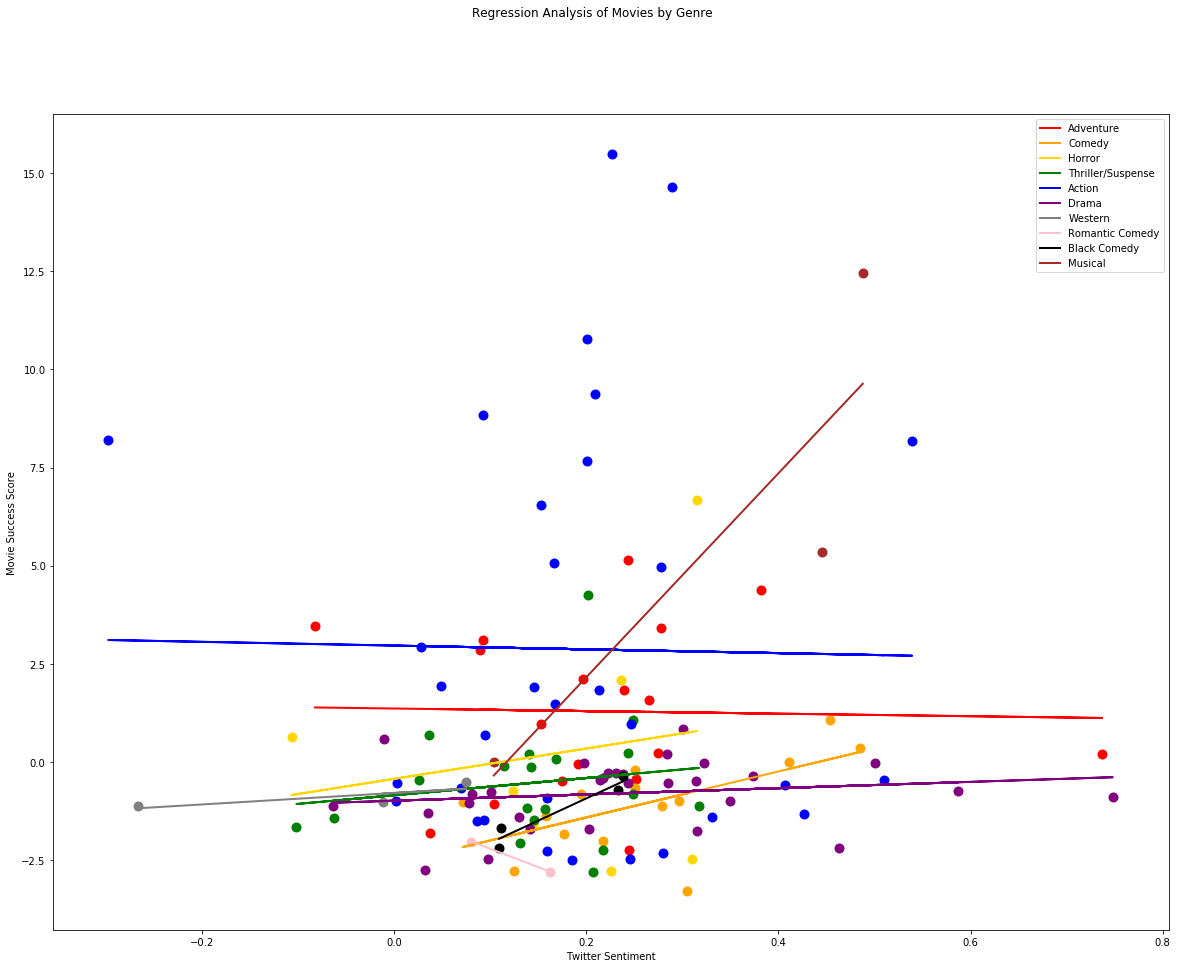

In [9]:
#2genre sentiment vs score with regression
colors = ["red","orange","gold","green","blue","purple","grey","pink","black","brown"]
g_list = []

fig, gx = plt.subplots(figsize=(20, 15))
# plt.figure(figsize=(10,7))

for x in np.arange(len(genres)):
    g = genres[x]
    genre = movie_data_df.loc[(movie_data_df['genre'] == g)]
    (gslope, gintercept, _, _, _) = stats.linregress(genre['compound'], genre['ztotal'])
    gfit = (gslope * genre['compound']) + gintercept
    g_dict = {"genre": g, "slope":gslope, "intercept":gintercept}
    g_list.append(g_dict)
    gx.plot(genre['compound'], gfit, color = colors[x], label = g, linewidth = 2)
    gx.scatter(genre['compound'], genre['ztotal'], s = 100, linewidth=0, marker="o", color=colors[x], label = None)
    gx.set_ylabel("Movie Success Score")
    gx.set_xlabel("Twitter Sentiment")
    gx.legend (loc='best', bbox_to_anchor=(1,1))
    fig.suptitle('Regression Analysis of Movies by Genre',size=12)
plt.savefig("GenreSentimentVsScoreRegression.jpg")
g_df = pd.DataFrame(g_list)

plt.show()

In [10]:
g_df.head(10)

,genre,intercept,slope
0,Adventure,1.359158,-0.327321
1,Comedy,-2.589761,5.860652
2,Horror,-0.433156,3.860717
3,Thriller/Suspense,-0.851549,2.195544
4,Action,2.962927,-0.478743
5,Drama,-0.990846,0.800627
6,Western,-0.793005,1.465265
7,Romantic Comedy,-1.283516,-9.328687
8,Black Comedy,-3.196825,11.329146
9,Musical,-3.041875,25.996464


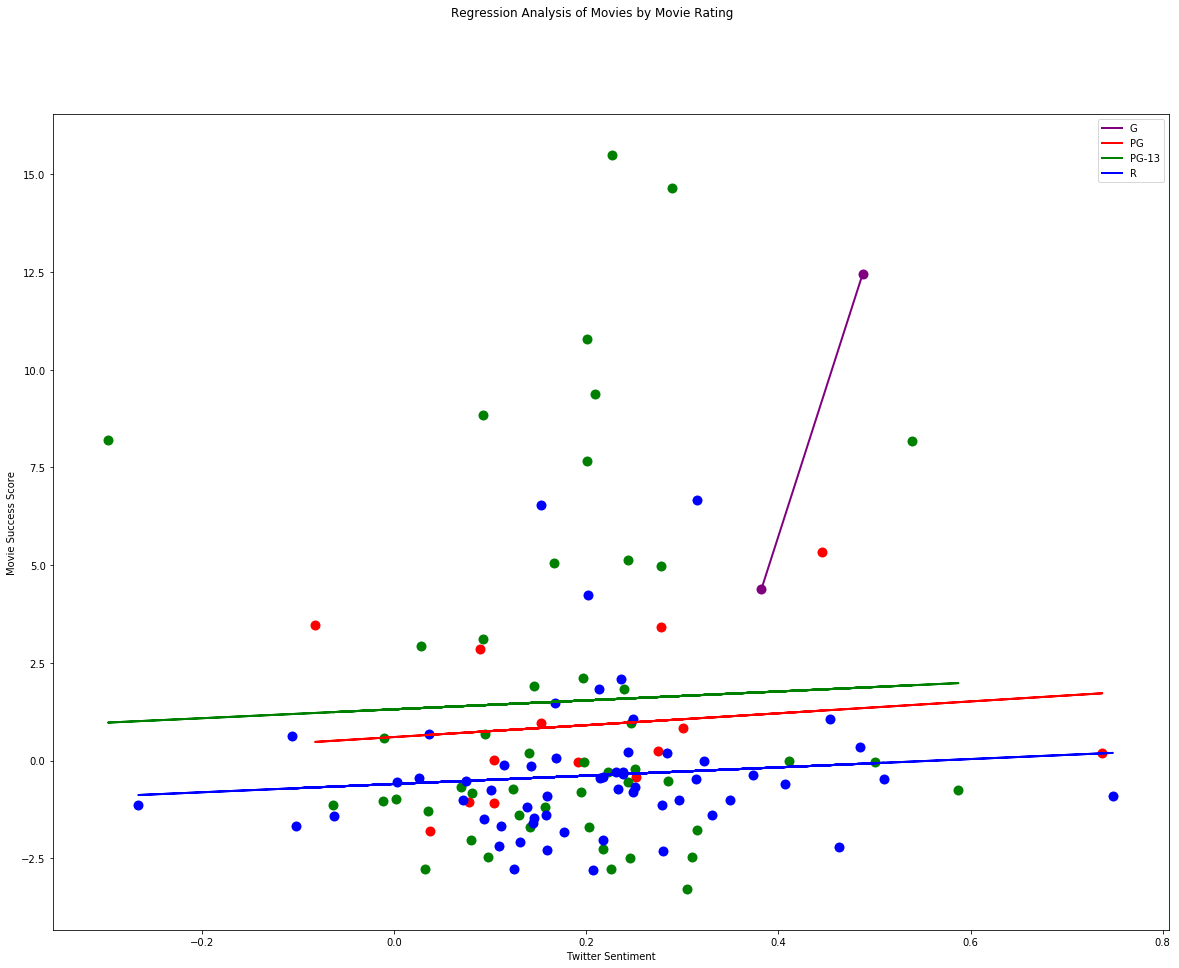

In [11]:
#3Matt: rated vs. successscore with regression
colors = ["purple","red","green","blue"]
rated = ["G","PG","PG-13","R"]
r_list = []


fig, rx = plt.subplots(figsize=(20, 15))
# plt.figure(figsize=(10,7))

for x in np.arange(len(rated)):
    r = rated[x]
    rate = movie_data_df.loc[(movie_data_df['rated'] == r)]
    (rslope, rintercept, _, _, _) = stats.linregress(rate['compound'], rate['ztotal'])
    rfit = (rslope * rate['compound']) + rintercept
    r_dict = {"rated": r, "slope":rslope, "intercept":rintercept}
    r_list.append(r_dict)
    rx.plot(rate['compound'], rfit, color = colors[x], label = r, linewidth = 2)
    rx.scatter(rate['compound'], rate['ztotal'], s = 100, linewidth=0, marker="o", color=colors[x], label = None)
    rx.set_ylabel("Movie Success Score")
    rx.set_xlabel("Twitter Sentiment")
    rx.legend (loc='best', bbox_to_anchor=(1,1))
    fig.suptitle('Regression Analysis of Movies by Movie Rating',size=12)
plt.savefig("RatedSentimentVsScoreRegression.jpg")
r_df = pd.DataFrame(r_list)
plt.show()

In [12]:
r_df[['rated','slope','intercept']]
r_df.head()

,intercept,rated,slope
0,-24.861032,G,76.519303
1,0.600905,PG,1.518773
2,1.310755,PG-13,1.141257
3,-0.600143,R,1.062666


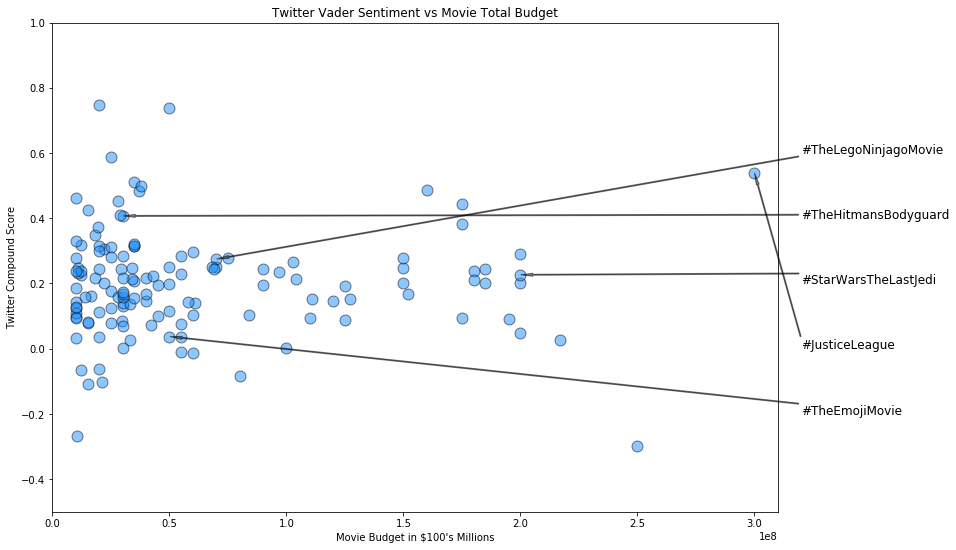

In [13]:
#4Jason: Vader Sentiment vs. Movie Total Budget
#Does Spending more on a movie, give it better twitter reviews?

# Set movie coordinates
movie_list = ["#TheEmojiMovie", "#JusticeLeague", "#StarWarsTheLastJedi", 
              "#TheHitmansBodyguard", "#TheLegoNinjagoMovie"]


plt.figure(figsize=(13, 9))
plt.ylim(-.5, 1)
plt.xlim(0, 310000000)

plt.scatter(movie_data_df["budget"], movie_data_df["compound"] ,linewidths = 1, alpha= .5, color = 'dodgerblue',edgecolor='black',s=120)
plt.title("Twitter Vader Sentiment vs Movie Total Budget")

plt.xlabel("Movie Budget in $100's Millions")
plt.ylabel("Twitter Compound Score")

ax=plt.gca()

x_text_coord = 320000000
y_text_coord = -0.2

for movie in movie_list:
    
    # Pinpoint values for coordinates
    coordinate_values = title_index_df.loc[movie,['budget', 'compound']]
    
    # Assign coordinates
    x_coord = coordinate_values['budget']
    y_coord = coordinate_values['compound']
    
    # Annotations
    ax.annotate(movie, xy=(x_coord, y_coord), xytext=(x_text_coord, y_text_coord), fontsize=12,
                arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
    
    # Increment text coordinates
    y_text_coord -= -.2


plt.savefig("BudgetVsTwitterSentiment.jpg")
plt.show()

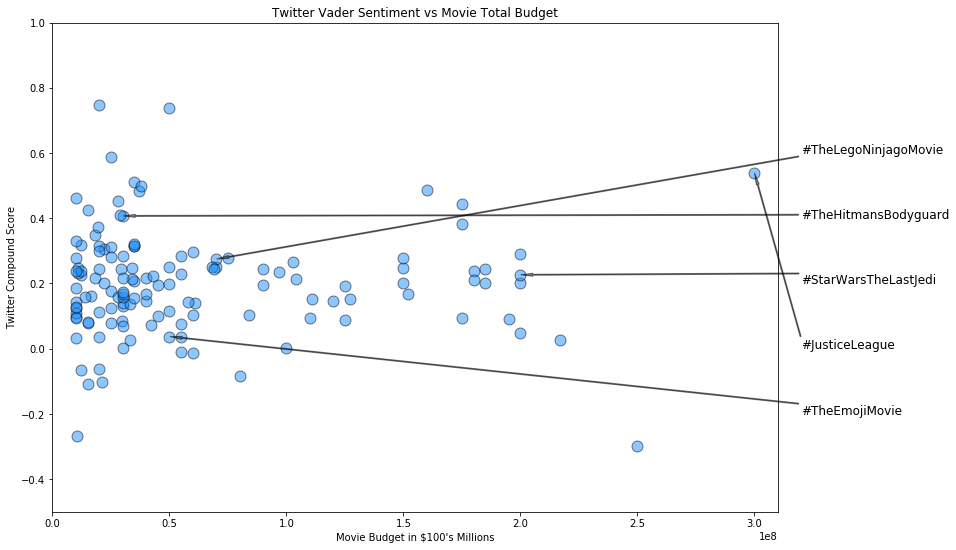

In [14]:
#5 Jason: Is our score able to predict success, based on opening weekend revenue? zoomed

movie_list = ["#TheEmojiMovie", "#JusticeLeague", "#StarWarsTheLastJedi", 
              "#TheHitmansBodyguard", "#TheLegoNinjagoMovie"]


plt.figure(figsize=(13, 9))
plt.ylim(-.5, 1)
plt.xlim(0, 310000000)

plt.scatter(movie_data_df["budget"], movie_data_df["compound"] ,linewidths = 1, alpha= .5, color = 'dodgerblue',edgecolor='black',s=120)
plt.title("Twitter Vader Sentiment vs Movie Total Budget")

plt.xlabel("Movie Budget in $100's Millions")
plt.ylabel("Twitter Compound Score")

ax=plt.gca()

x_text_coord = 320000000
y_text_coord = -0.2

for movie in movie_list:
    
    # Pinpoint values for coordinates
    coordinate_values = title_index_df.loc[movie,['budget', 'compound']]
    
    # Assign coordinates
    x_coord = coordinate_values['budget']
    y_coord = coordinate_values['compound']
    
    # Annotations
    ax.annotate(movie, xy=(x_coord, y_coord), xytext=(x_text_coord, y_text_coord), fontsize=12,
                arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
    
    # Increment text coordinates
    y_text_coord -= -.2

plt.savefig("ScoreVsOpeningRegression.png")
plt.show()

In [15]:
sns.set_style("dark", {'grid.linestyle': '--'})
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2} 
sns.set(rc={'figure.figsize':(8,5)})

# locating tweet count>10
movie_data_tc10_df = movie_data_df.loc[(movie_data_df['tweet_count']>10)]
movie_data_tc10_df.head()

for index,row in movie_data_tc10_df.iterrows():
    date =str(row['release'])
    year = date[:4]
    month = date[4:6]
    year_month = str(year) + str(month)
    
    #print(month)
    movie_data_tc10_df.set_value(index,'release', str(year_month))
    #movie_data_tc10_df['release'].apply(lambda year_month: datetime.strptime(str(year_month),'%Y%m'))
# movie_data_tc10_df.head()
# y-axis for the plot (opening weekend revenue)
opening_weekend_rev = movie_data_tc10_df.groupby(movie_data_tc10_df["release"])["opening"].sum()
opening_weekend_rev_df = pd.DataFrame(opening_weekend_rev)
opening_weekend_rev_df = opening_weekend_rev.reset_index()
opening_weekend_rev_df.rename(columns={"opening": "total opening by month"}, inplace=True)
opening_weekend_rev_df["release"] = opening_weekend_rev_df["release"].astype(str)
#print(opening_weekend_rev_df.dtypes)
# opening_weekend_rev_df

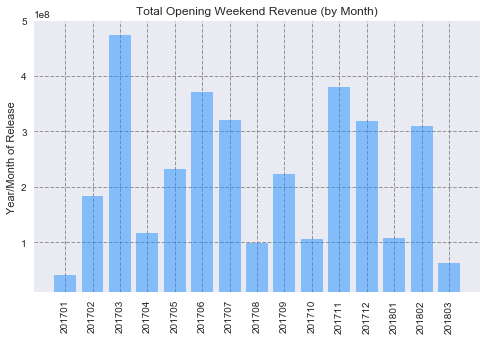

In [16]:
#6Shilpa Revenue by Month
# y-axis for the plot (opening revenue)
opening_weekend_rev_y = opening_weekend_rev_df["total opening by month"]

# x-axis for the plot (release data)
date_open_x = opening_weekend_rev_df["release"]

# plot the barplot
bar_plot = plt.bar(date_open_x, opening_weekend_rev_y, alpha=0.5, align="edge", color="dodgerblue")
# (Or) using seaborn

# Tell matplotlib where we would like to place each of our x axis headers
tick_locations = np.arange(len(opening_weekend_rev_df))
plt.xticks(tick_locations+0.4, opening_weekend_rev_df["release"], rotation="vertical")

# set the x and y axis limits and labels, chart title and legends 
plt.ylim(10000000, 500000000)
plt.title("Total Opening Weekend Revenue (by Month)")
plt.ylabel("Year/Month of Release")
plt.grid(linestyle='--', color='grey', alpha=0.8)
plt.axhline(0)

# Save our graph and show the graph
plt.savefig("RevenueByMonth.jpg")
plt.show()

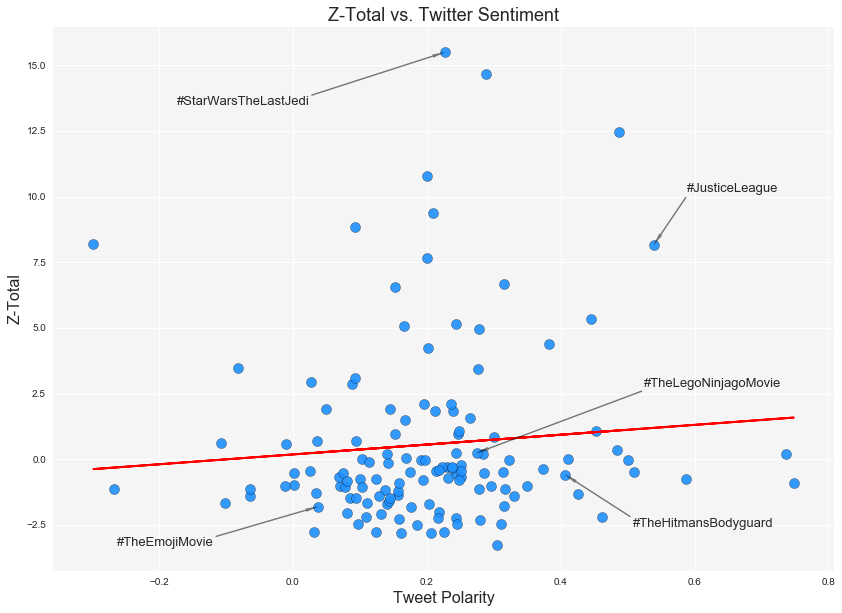

In [17]:
# Set axes
ztotal = movie_data_df['ztotal']
compound = movie_data_df['compound']

# Set movie coordinates
movie_list = ["#TheEmojiMovie", "#JusticeLeague", "#StarWarsTheLastJedi", 
              "#TheHitmansBodyguard", "#TheLegoNinjagoMovie"]

movie_coord = {}


# Set figure size
plt.figure(figsize=(14, 10))

zx = plt.subplot()
(zslope, zintercept, _, _, _) = stats.linregress(title_index_df['compound'], title_index_df['ztotal'])
zfit = (zslope * title_index_df['compound']) + zintercept
zx.plot(title_index_df['compound'], zfit, color = "r", linewidth = 2)
z_df = pd.DataFrame({"slope":[zslope], "intercept":[zintercept]})

# Create plot
plt.scatter(compound, ztotal, marker="o", s=100, facecolor='dodgerblue', edgecolor='black', alpha=0.9)

# Set limits
# plt.xlim(-1, 1)

# Labels
plt.title('Z-Total vs. Twitter Sentiment', fontsize=18)
plt.xlabel('Tweet Polarity', fontsize=16)
plt.ylabel('Z-Total', fontsize=16)

# Set axes background color
ax = plt.gca()
ax.set_facecolor('whitesmoke')

# Insert grid lines and set behind plot elements
ax.grid(color='white')
ax.set_axisbelow(True)

# Grab coordinates
for movie in movie_list:
    
    # Pinpoint values for coordinates
    coordinate_values = title_index_df.loc[movie,['ztotal', 'compound']]
    
    # Assign coordinates
    x_coord = coordinate_values['compound']
    y_coord = coordinate_values['ztotal']
    
    # Add coordinates for each movie to dictionary
    movie_coord[movie] = [x_coord, y_coord]

# Annotations
ax.annotate("#TheEmojiMovie", xy=(movie_coord["#TheEmojiMovie"][0], movie_coord["#TheEmojiMovie"][1]), 
            xytext=(movie_coord["#TheEmojiMovie"][0]-0.3, movie_coord["#TheEmojiMovie"][1]-1.5), 
            fontsize=13, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#JusticeLeague", xy=(movie_coord["#JusticeLeague"][0], movie_coord["#JusticeLeague"][1]), 
            xytext=(movie_coord["#JusticeLeague"][0]+0.05, movie_coord["#JusticeLeague"][1]+2), 
            fontsize=13, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#StarWarsTheLastJedi", xy=(movie_coord["#StarWarsTheLastJedi"][0], movie_coord["#StarWarsTheLastJedi"][1]), 
            xytext=(movie_coord["#StarWarsTheLastJedi"][0]-0.4, movie_coord["#StarWarsTheLastJedi"][1]-2), 
            fontsize=13, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#TheHitmansBodyguard", xy=(movie_coord["#TheHitmansBodyguard"][0], movie_coord["#TheHitmansBodyguard"][1]), 
            xytext=(movie_coord["#TheHitmansBodyguard"][0]+0.1, movie_coord["#TheHitmansBodyguard"][1]-2), 
            fontsize=13, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#TheLegoNinjagoMovie", xy=(movie_coord["#TheLegoNinjagoMovie"][0], movie_coord["#TheLegoNinjagoMovie"][1]), 
            xytext=(movie_coord["#TheLegoNinjagoMovie"][0]+0.25, movie_coord["#TheLegoNinjagoMovie"][1]+2.5), 
            fontsize=13, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))

# Save and show
# plt.savefig('images/ztotal_vs_sentiment.png')
plt.show()

In [18]:
z_df

,intercept,slope
0,0.18012,1.875866


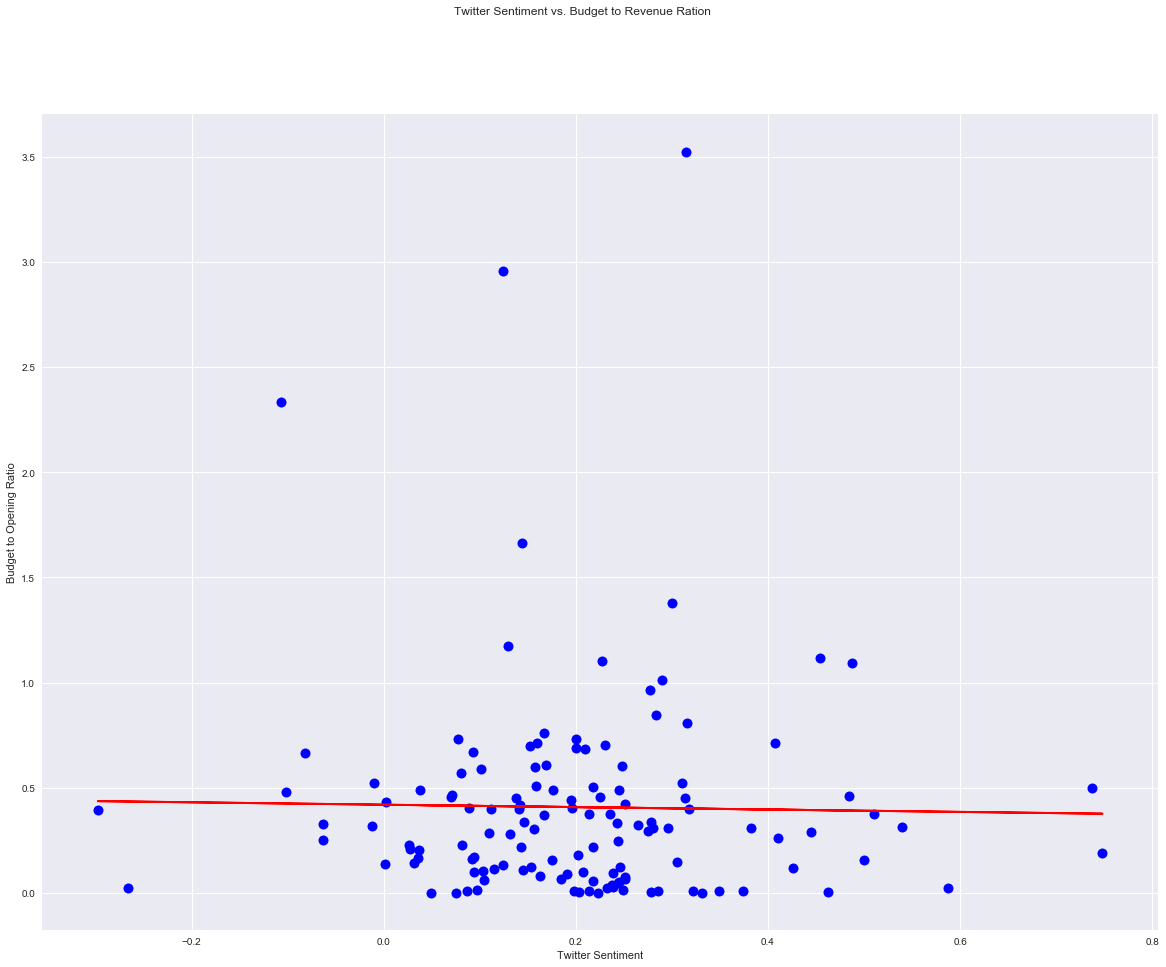

In [19]:
# 8 maybe a scatter plot of twitter sentiment and budget/rev ratio

fig, brx = plt.subplots(figsize=(20, 15))
# plt.figure(figsize=(10,7))

(brslope, brintercept, _, _, _) = stats.linregress(movie_data_df['compound'], movie_data_df['ratio'])
brfit = (brslope * movie_data_df['compound']) + brintercept
brx.plot(movie_data_df['compound'], brfit, color = "red", linewidth = 2)
brx.scatter(movie_data_df['compound'], movie_data_df['ratio'], s = 100, linewidth=0, marker="o", color="blue", label = None)
brx.set_ylabel("Budget to Opening Ratio")
brx.set_xlabel("Twitter Sentiment")
# brx.legend (loc='best', bbox_to_anchor=(1,1))
fig.suptitle('Twitter Sentiment vs. Budget to Revenue Ration',size=12)
plt.savefig("SentimentVsBRRatio.jpg")
plt.show()


In [20]:
movie_query = input("What Movie would you like to search? ")
omdbapi = "e8913e4c"
omdb1 = "http://www.omdbapi.com/?t="
omdb2 = "&apikey="

moviedbapi = "87594855563381b8f9fa3b3224c9f19f"
idURL = "https://api.themoviedb.org/3/search/movie?query="
idURL1 = "&api_key="
detailURL = "https://api.themoviedb.org/3/movie/"
detailURL1 = "?api_key="

#prepare to search by twitter hashtag
movie_search = movie_query.replace(" ","")
movie_search = movie_search.replace(":","")
movie_search = movie_search.replace("’","")
movie_search = movie_search.replace(".","")
movie_search = movie_search.replace(",","")
movie_search = movie_search.replace("!","")
movie_search = movie_search.replace("?","")
movie_search = movie_search.replace("-","")
movie_search = movie_search.replace("&","")
movie_search = movie_search.replace("$","")
movie_search = "#" + movie_search
# print (movie_query)
# print (f'Searching Twitter for {movie_search}')
publicTweets = api.search(movie_search, count = 100)
compoundList = []
for tweet in publicTweets['statuses']:
    text = tweet['text']
    results = analyzer.polarity_scores(text)
    compound = results['compound']
    compoundList.append(compound)
twitter_compound = np.mean([compoundList])
print (f'{movie_query} has a Vader Compound Score of {twitter_compound.round(2)}')
#-----------------------------------------------------------------------
# print ('Searching API')
omdb_url = omdb1 + movie_query + omdb2 + omdbapi
# print (omdb_url)
try:
    q_json = requests.get(omdb_url).json()
    rated = q_json['Rated']
    rated_col = r_df['rated']
#     print(rated_col)
    counter = 0
    for name in rated_col:
        if name == rated:
            r_index = counter
        else:
            counter = counter + 1
    r_int = r_df['intercept'][r_index]
    r_m = r_df['slope'][r_index]
    rscore = (r_int + (r_m * twitter_compound)).round(2)
    print (f'{movie_query} is rated: {rated}')
    print (f'Based on this rating, we expect a Movie Success Score of {rscore}')
    
except:
    print (f'Could not find rating for {movie_query}')
    
print ("---------------------------------------------------------------------------------")

id_query = idURL + movie_query + idURL1 + moviedbapi
# print (id_query)
try:
    moviedbquery = requests.get(id_query).json()
    movie_idnumber = moviedbquery['results'][0]['id']
#     print (movie_idnumber)
    details_URL = detailURL + str(movie_idnumber) + detailURL1 + moviedbapi
#     print (details_URL)
    details_URL_json = requests.get(details_URL).json()
    genreList = []
    for entry in details_URL_json['genres']:
#         print (entry)
        g_name = entry['name']
        genreList.append(g_name)
#     print (genreList)
    for genre in genreList:
        for g in genres:
            if genre == g:
                matchGenre = genre
    g_counter = 0
    for name in genres:
        if name == matchGenre:
            g_index = g_counter
        else:
            g_counter = g_counter + 1
#     print (g_index)
    g_int = g_df['intercept'][g_index]
#     print (g_int)
    g_m = g_df['slope'][g_index]
#     print (g_m)
    g_score = (g_int + (g_m * twitter_compound)).round(2)
    print (f"{movie_query} has the genre: {matchGenre}")
    print (f'Based on this genre, we expect a Movie Success Score of {g_score}')
except:
    print (f"Could not find a genre match for {movie_query}")
print ("---------------------------------------------------------------------------------")

z_score = (zintercept + (zslope * twitter_compound)).round(2)
print (f'Based on Vader Sentiment Analysis, we expect an overall Movie Success Score of {z_score}')

What Movie would you like to search? The Bourne Identity
The Bourne Identity has a Vader Compound Score of 0.36
The Bourne Identity is rated: PG-13
Based on this rating, we expect a Movie Success Score of 1.72
---------------------------------------------------------------------------------
The Bourne Identity has the genre: Drama
Based on this genre, we expect a Movie Success Score of -0.7
---------------------------------------------------------------------------------
Based on Vader Sentiment Analysis, we expect an overall Movie Success Score of 0.86
